In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST


Là dataset của bộ số viết tay


In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

Có 70000 ảnh, mỗi ảnh có 784 features (28 $\times$ 28 pixels)


In [7]:
import matplotlib.pyplot as plt


def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

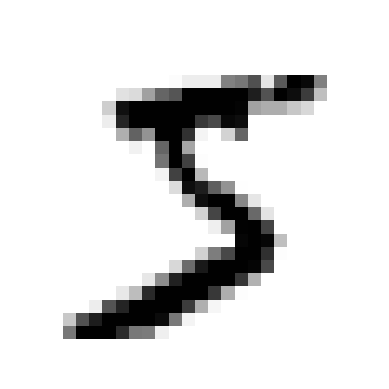

In [8]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

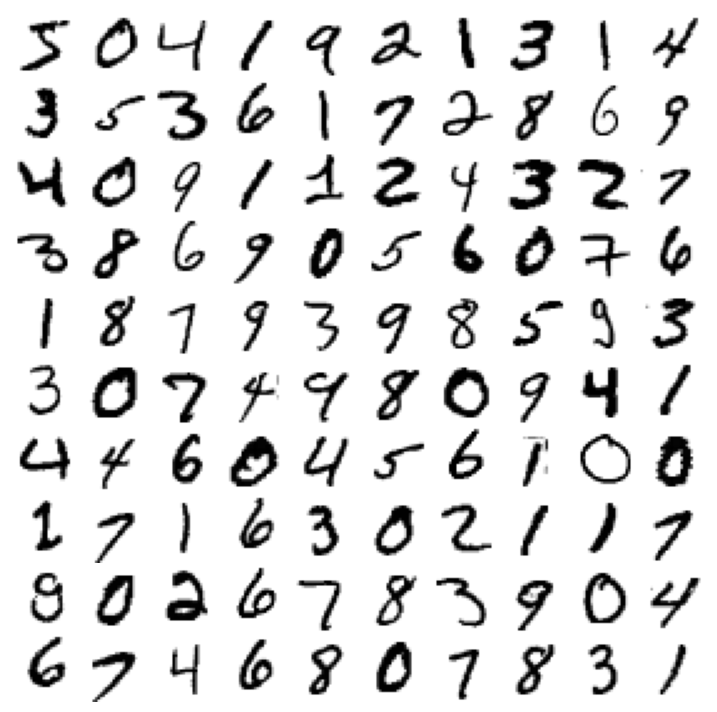

In [10]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [11]:
# split train test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Bài toán: phân biệt chữ số 5 và không phải chữ số 5

In [12]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

Nghĩa là ảnh được truyền vào được dự đoán là đúng (tức số 5)

# Performance Measures

Việc đánh giá một `Classifier` khó khăn hơn so với `Regressor`

## Measuring Accuracy Using Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 95% là một kết quả rất tốt
- Thử lại với `Dummy Classifier` với tham số mặc định `strategy="most_frequent"` hàm predict sẽ luôn trả về nhãn phổ biển nhất trong tập train

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected
import numpy as np

dummy_clf.predict(np.array([some_digit]))

False


array([False])

In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [18]:
# try implement cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_fold, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.0
0.0
0.0


Độ chính xác đạt 90%. Có nghĩa là có khoảng 10% là số 5. Vậy nếu ta dự đoán `not 5` có đến 90% cơ hội chính xác. Điều này là lí do tại sao `accuracy` thường không phải công cụ đo hiệu suất được ưu tiên cho các bài toán phân loại đặc biệt với `skewed datasets (tập dữ liệu bị lệch, tức là có vài lớp nhiều hơn hẳn các lớp còn lại)`
Một trong những cách thường được dùng là sử dụng `confusion matrix`

## Confusion Matrices

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Mỗi dòng trong `confusion_matrix` đại diện cho một `actual class`, trong khi đó mỗi cột là `predicted class`. Các số liệu tương ứng là $\begin{bmatrix}TN & FP \\ FN & TP\end{bmatrix}$. $FP$ được gọi là gọi là lỗi loại 1 và $FN$ là lỗi loại 2



![](https://i.ibb.co/G4c2HFgx/metric.png)

## Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [22]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

Tức khi dự đoán là số 5 nó chỉ đúng 83,7% và nó phát hiện được 65.1% là số 5

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

Trong vài trường hợp chúng ta quan tâm đến precision, trong trường hợp khác là recall. Vì dụ, nếu chúng ta đã huấn luyện một classifier để phân loại video an toàn cho trẻ chúng ta muốn mô hình từ chối nhiều video tốt (recall thấp) nhưng chỉ giữ lại những video an toàn (precision cao). Mặt khác, giả sử bạn đào tạo một bộ phân loại để phát hiện kẻ trộm vặt trong hình ảnh giám sát, model chỉ có khoảng 30% precision nhưng có 99% recall, tức là có thể cảnh báo sai nhưng đa số kẻ trộm sẽ bị phát hiện.

Tăng recall sẽ làm giảm precision và ngược lại đó là `precision/recall trade-off`

## The Precision/Recall Trade-off

`SGDClassifier` với mỗi mẫu nó sẽ tính toán điểm dựa trên `decision function` và so sánh điểm đó với một ngưỡng để xem mẫu đó là positive hay negative

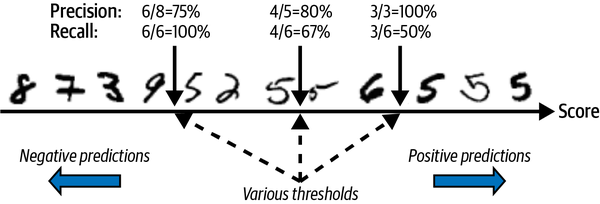


Scikit-Learn không cho phép thiết lập `threshold` trực tiếp, nhưng nó cho phép bạn truy cập vào `scores` mà nó sử dụng để đưa ra dự đoán bằng `decision_function()` của nó, phương thức này trả về điểm cho mỗi trường hợp, sau đó sử dụng bất kỳ ngưỡng nào bạn muốn để đưa ra dự đoán dựa trên các điểm đó:

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Ta có thể thấy ngưỡng tăng sẽ làm giảm recall. Ảnh mẫu thực sự là số 5 và model đã dự đoán sai khi ngưỡng tăng lên thành 3000

Làm thế nào để quyết định ngưỡng nào được sử dụng?

- Đầu tiên sử dụng `cross_val_predict()` để tính `scores` của tất cả các mẫu trong tập train và chỉ rõ rằng muốn decision_score thay vì prediction

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

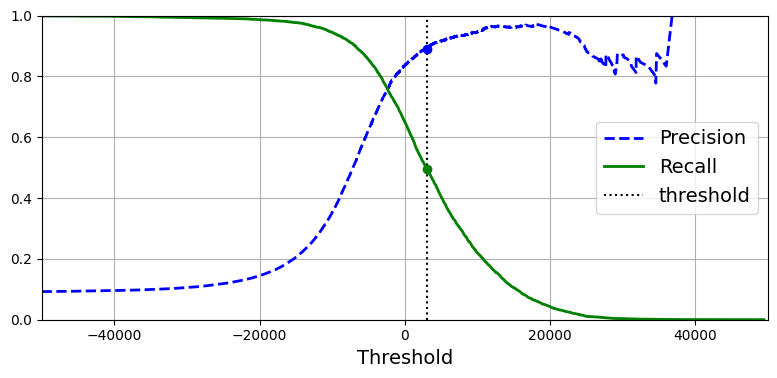

In [29]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis((-50000, 50000, 0, 1))
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

Tại điểm được đánh dấu, precision gần 90% và recall khoảng 50%. 

Một cách khác là để chọn là biểu diễn precision trực tiếp  theo recall

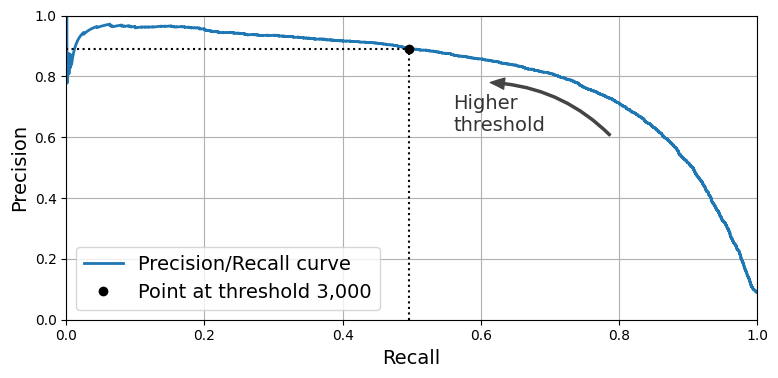

In [30]:
from cProfile import label
import matplotlib.patches as patches

plt.figure(figsize=(8, 4))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis((0, 1, 0, 1))
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

Giả sử mục tiêu của chúng ta là 90% precision

In [31]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [32]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [34]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

np.float64(0.4799852425751706)

## The ROC Curve

`Receiver operating characteristic (ROC)` curve là một công cụ thường được sử dụng trong `binary classifiers`. Nó gần giống với đường `precision/recall` nhưng thay vì biểu diễn `precision` với `recall`, ROC biểu diễn  `true positive rate (recall)` với `fall positive rate (FPR)`. `FPR (fall-out)` là tỷ lệ các trường hợp negative được
phân loại không chính xác là positive. `True Negative Rate (TNR also called Specificity)`

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

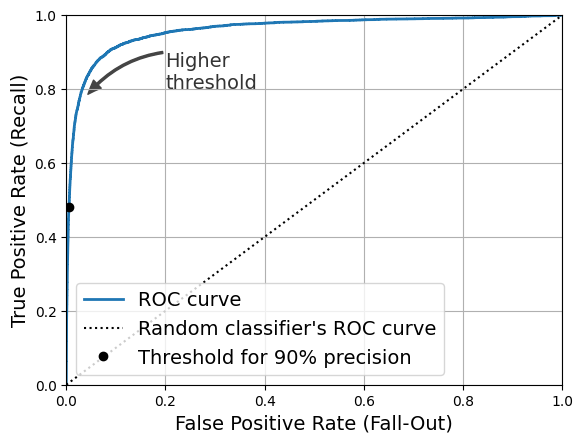

In [36]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.2, 0.9), (0.04, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.2, 0.8, "Higher\nthreshold", color="#333333")

plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.axis((0, 1, 0, 1))
plt.grid()
plt.legend(loc="lower left")

plt.show()

Một cách để so sánh giữa 2 classifiers là đo `area under the curve (AUC)`. Một classifiers hoàn hảo có ROC AUC = 1, trong khi các `random classifier` sẽ có ROC AUC bằng 0.5

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

Sử dụng RandomForestClassifier để so sánh với SGDClassifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

In [39]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

Mỗi dòng là xác suất mẫu đó negative và positive

In [41]:
# The second column is the probability of the positive class (5s)

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
y_train_5, y_scores_forest)

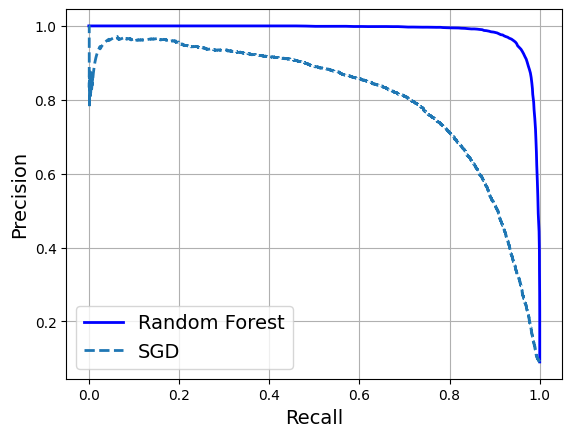

In [42]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.show()

In [43]:

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

np.float64(0.9274509803921569)

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [45]:
precision_score(y_train_5, y_train_pred_forest)

np.float64(0.9897468089558485)

In [46]:
recall_score(y_train_5, y_train_pred_forest)

np.float64(0.8725327430363402)

# Multiclass Classification

In [47]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])


SVC(random_state=42)

In [48]:
svm_clf.predict(np.array([some_digit]))

array(['5'], dtype=object)

In [49]:
from sklearn.manifold import smacof


some_digit_scores = svm_clf.decision_function(np.array([some_digit]))
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [50]:
# get class in model

svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [51]:
# force use one vs rest

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [52]:
ovr_clf.predict(np.array([some_digit]))

array(['5'], dtype='<U1')

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
# train SGD for multiclass classification
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(np.array([some_digit]))

array(['3'], dtype='<U1')

In [55]:
sgd_clf.decision_function(np.array([some_digit])).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [56]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
# try implement standardization to improve performance

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

# Error Analysis

Sau khi đã trải qua các bước và xây dựng được một mô hình hứa hẹn chúng ta cần tìm cách cải thiện nó. Một cách để thực hiện điều này là phân tích các loại lỗi mà nó gây ra

In [57]:
# first, look at the confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [58]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix")
plt.show()

Kết quả khá tốt hầu hết các hình ảnh đều nằm trên đường chéo chính (dự đoán đúng). Cột thứ 5 và hàng thứ 5 có vẻ tối hơn một chút có nghĩa là model có nhiều lỗi ở nhãn 5 hoặc có ít mẫu 5 hơn.

In [59]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.title("CM normalized by row")
plt.show()

- Ta có thể thấy rằng chỉ có 82% hình ảnh của 5 được phân loại đúng. Lỗi phổ biến nhất mà mô hình mắc phải với hình ảnh của 5 là phân loại sai thành 8: điều này xảy ra với 10% trong số tất cả 5. Nhưng chỉ có 2% trong số 8 bị phân loại sai thành 5
- Có khá nhiều số khác cũng bị nhầm thành 8

In [60]:
sample_weight = (y_train_pred != y_train)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

- Ở hình bên trái `normalize="true"`, ta đã loại trừ các dự đoán đúng.

Ví dụ ở dòng 7 cột 9, có nghĩa là 36% dự đoán sai của class 7 là 9

- Ở hình bên phải `normalize="pred"`

Ví dụ ở dòng 9 cột 7, có nghĩa là 56% dự đoán sai của 7 thực sự là 9

Phần tích `confusion matrix` thường cung cấp cho bạn những hiểu biết sâu sắc về cách cải thiện classifier. 

Khi nhìn vào các biểu đồ này, ta nên tập trung vào việc giảm số 8 sai.

# Multilabel Classification

In [61]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [62]:
y_multilabel[:10]

In [63]:
knn_clf.predict(np.array([some_digit]))

Có nhiều cách để đánh giá `Multilabel classifier`, một cách tiếp cận là đo $F_1 score$ cho mỗi nhãn, sau đó tính điểm trung bình

In [64]:
# F_1 score across all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

Cách tiếp cận này cho rằng tất cả các label đều quan trọng như nhau, trong thực tế có thể không phải vậy. Đặc biệt là khi có một nhãn nhiều hơn các nhãn còn lại. Một cách đơn giản là đặt trọng số cho mỗi nhãn bằng mức hỗ trợ của nó (Ex. số lượng mẫu có nhãn đó). Để làm điều này đặt `average="weighted"`
 

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

Nếu muốn sử dụng một classifier không hỗ trợ multilabel, như SVC. Một chiến lược khả thi là huấn luyện một mô hình cho mỗi nhãn. Tuy nhiên chiến lược này gặp khó trong việc nắm bắt phục thuộc giữa mỗi nhãn. Ví dụ, một chữ số lớn (7, 8 hoặc 9) có khả năng là số lẻ gấp đôi số chẵn, nhưng bộ phân loại cho nhãn "lẻ" không biết bộ phân loại cho nhãn "lớn" dự đoán điều gì. Để giải quyết vấn đề này, các mô hình có thể được sắp xếp theo chuỗi: khi một mô hình đưa ra dự đoán, nó sử dụng các tính năng đầu vào cộng với tất cả các dự đoán của các mô hình đi trước nó trong chuỗi 

Scikit-learn cung cấp một giải pháp là `ChainClassifier`. Chúng sẽ sử dụng nhãn thật để huấn luyện, cung cấp cho mỗi mô hình các nhãn phù hợp tùy thuộc vào vị trí của chúng trong chuỗi. Nhưng nếu bạn đặt siêu tham số cv, nó sẽ sử dụng xác thực chéo để có được các dự đoán "sạch" (ngoài mẫu) từ mỗi mô hình đã đào tạo cho mọi trường hợp trong tập đào tạo và sau đó các dự đoán này sẽ được sử dụng để đào tạo tất cả các mô hình sau đó trong chuỗi

In [66]:
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42) # type: ignore
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [67]:
chain_clf.predict([some_digit])

# Multioutput Classification

Nó là một trường hợp khái quát của multilabel classification, mỗi label có thể có multiclass (nó có thể nhiều hơn hai giá trị khả thi) 

Ví dụ, thử xây dựng hệ thống loại bỏ nhiễu từ hình ảnh. Nó sẽ lấy đầu vào là một hình ảnh số nhiễu và (hy vọng) sẽ cho ra một hình ảnh số sạch, được biểu diễn dưới dạng một mảng cường độ điểm ảnh, giống như hình ảnh MNIST

In [68]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [69]:
# extra code – this cell generates and saves Figure 3–12
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [70]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]]) # type: ignore
plot_digit(clean_digit)
plt.show()

# Exercises

## 1

Question: Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"],
               'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])


In [72]:
grid_search.best_params_

In [73]:
grid_search.best_score_

In [74]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

## 2

Question: Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [75]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [77]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [82]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [83]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [84]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [86]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [87]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

In [88]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

## 3

Tackle the Titanic dataset. A great place to start is on Kaggle.
Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files, train.csv and test.csv, which you can load using pandas.read_csv(). The goal is to train a classifier that can predict the Survived column based on the other columns.

In [89]:
# fetch dataset

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_titanic_data():
    tarball_path = tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename) for filename in ("train.csv", "test.csv")]

In [91]:
train_data, test_data = load_titanic_data()

train_data.head()

The attributes have the following meaning:

- **PassengerId**: a unique identifier for each passenger

- **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.

- **Pclass**: passenger class.

- **Name**, Sex, Age: self-explanatory

- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.

- **Parch**: how many children & parents of the passenger aboard the Titanic.

- **Ticket**: ticket id

- **Fare**: price paid (in pounds)

- **Cabin**: passenger's cabin number

- **Embarked**: where the passenger embarked the Titanic

In [92]:
train_data.info()

In [93]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

**Age**, **Cabin**, **Embarked** có nhiều ô dữ liệu trống. **Cabin** có thể được loại bỏ

Thuộc tính **Age** có khoảng 19% giá trị null, vì vậy chúng ta sẽ cần quyết định phải làm gì với chúng. Thay thế các giá trị null bằng tuổi trung bình có vẻ hợp lý. Chúng ta có thể thông minh hơn một chút bằng cách dự đoán độ tuổi dựa trên các cột khác (ví dụ: tuổi trung bình là 37 ở class 1, 29 ở class 2 và 24 ở class 3), nhưng chúng ta sẽ giữ mọi thứ đơn giản và chỉ sử dụng độ tuổi trung bình tổng thể.

In [96]:
train_data.describe()

In [97]:
train_data["Survived"].value_counts()

In [98]:
train_data["Pclass"].value_counts()

In [99]:
train_data["Sex"].value_counts()

In [100]:
train_data["Embarked"].value_counts()

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("impputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [102]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse_output=False))
])

In [103]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [104]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

In [105]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, train_data["Survived"])

In [106]:
X_test = preprocess_pipeline.transform(test_data)
y_test = forest_clf.predict(X_test)

In [108]:
y_train = train_data["Survived"]

In [109]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

In [110]:
# try SVC
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

## 4

Build a spam classifier

* _Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin)._
* _Unzip the datasets and familiarize yourself with the data format._
* _Split the datasets into a training set and a test set._
* _Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello," "how," "are," "you," then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are" is absent, "you" is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word._

In [28]:
import tarfile
from pathlib import Path

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [29]:
ham_dir, spam_dir = fetch_spam_data()

In [30]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 0]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 0]

In [31]:
print(len(ham_filenames))
print(len(spam_filenames))

2501
501


In [32]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [33]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [8]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [36]:
print(spam_emails[4].get_content().strip())

I thought you might like these:
1) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.freeyankee.com/cgi/fy2/to.cgi?l=822slim1

2) Fight The Risk of Cancer! 
http://www.freeyankee.com/cgi/fy2/to.cgi?l=822nic1 

3) Get the Child Support You Deserve - Free Legal Advice 
http://www.freeyankee.com/cgi/fy2/to.cgi?l=822ppl1

Offer Manager
Daily-Deals








If you wish to leave this list please use the link below.
http://www.qves.com/trim/?social@linux.ie%7C29%7C134077


-- 
Irish Linux Users' Group Social Events: social@linux.ie
http://www.linux.ie/mailman/listinfo/social for (un)subscription information.
List maintainer: listmaster@linux.ie


In [37]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()


In [10]:
    
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [38]:
structures_counter(ham_emails).most_common()

[('text/plain', 2409),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [39]:
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [41]:
# preprocessing the data

import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [47]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[8]
print(sample_html_spam.get_content().strip()[:1000], "...")

<html>

<head>
<title>Home Page</title>
</head>

<body>

<p align="center"><font color="#000000" face="Arial" size="+0"><b><IMG SRC="http://mail4.mortgages101.net/logo.php?id=88&id2=1143953"></p>

<p align="center">If this promotion has reached you in error and you would prefer not to
receive marketing messages from us, please send an email to&nbsp; <a
href="mailto:cease-and-desist@mortgages101.net">cease-and-desist@mortgages101.net</a>
&nbsp; (all one word, no spaces) giving us the email address in question or call
1-888-748-7751 for further assistance.</p>

<p align="center"><u>Gain access to a</b></font><font size="+1" color="#000000"
face="Arial"> <i><b>Vast Network Of Qualified Lenders at Nationwide Network!</b></i></font></u></p>

<p align="center"><font color="#000000" face="Arial">This is a zero-cost service which
enables you to shop for a mortgage conveniently from your home computer. &nbsp; Our
nationwide database will give you access to lenders with a variety of loan program

In [48]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


If this promotion has reached you in error and you would prefer not to
receive marketing messages from us, please send an email to   HYPERLINK cease-and-desist@mortgages101.net
  (all one word, no spaces) giving us the email address in question or call
1-888-748-7751 for further assistance.
Gain access to a Vast Network Of Qualified Lenders at Nationwide Network!
This is a zero-cost service which
enables you to shop for a mortgage conveniently from your home computer.   Our
nationwide database will give you access to lenders with a variety of loan programs that
will work for Excellent, Good, Fair or even Poor Credit!
  We will choose up to 3 mortgage companies
from our database of  registered brokers/lenders. Each will contact you to offer you their best rate and terms - at
no charge.
 
 You choose the best
offer and save -  HYPERLINK  Shop here for your next mortgage with just ONE
CLICK -
 
Poor or Damaged Credit Is
Not A Problem!
  Consolidate & pay
  off high interest bills for one

In [49]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [50]:
print(email_to_text(sample_html_spam)[:100], "...")


If this promotion has reached you in error and you would prefer not to
receive marketing messages f ...


In [52]:
import nltk

# giảm từ về gốc
stemmer = nltk.PorterStemmer()

# example
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [55]:
import urlextract

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://scikit-learn.org/stable/ asbsd https://googlemaps.com"
print(url_extractor.find_urls(some_text))

['github.com', 'https://scikit-learn.org/stable/', 'https://googlemaps.com']


In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom transformer
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [60]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom': 1, 'most': 1, 'pervert': 1, 'system': 1, 'that': 1, 'ever': 1, 'shone': 1, 'man': 1

In [61]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [63]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors.toarray()

array([[104,  11,   9,   0,   8,   1,   2,   3,   0,   3,   2],
       [ 68,   0,   1,   1,   2,   4,   0,   3,   0,   1,   1],
       [ 94,   6,   3,  14,   0,   3,   6,   2,   6,   1,   2]])

In [64]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'number': 3,
 'and': 4,
 'url': 5,
 'i': 6,
 'to': 7,
 'kernel': 8,
 'all': 9,
 'on': 10}

In [65]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

np.float64(0.9841723886808156)

In [67]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 98.02%
Recall: 95.19%
